## Configurações

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configurar visualizações
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
df = pd.read_csv('../data/input/creditcard_clean.csv')

## Pré-Processamento

In [3]:
features = df.columns[:-1]
target = df.columns[-1]

print(f'Features: {features}')
print(f'Target: {target}')

Features: Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')
Target: Class


In [4]:
y = df['Class']
X = df.drop('Class', axis=1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
def calculate_metrics(y_true, y_pred, y_proba, model_name):
    report = classification_report(y_true, y_pred, output_dict=True)
    return {
        "Modelo": model_name,
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1": report["1"]["f1-score"],
    }

## Random Forest Normal

In [16]:
rf_normal = RandomForestClassifier(random_state=42, oob_score=True)

In [17]:
rf_normal.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [18]:
y_pred_test = rf_normal.predict(X_test)

In [19]:
y_pred_train = rf_normal.predict(X_train)

In [20]:
results_normal_test = calculate_metrics(y_test, y_pred_test, rf_normal.predict_proba(X_test)[:,1], "Normal")
results_normal_train = calculate_metrics(y_train, y_pred_train, rf_normal.predict_proba(X_train)[:,1], "Normal")

In [21]:
cm_normal = confusion_matrix(y_test, y_pred_test)

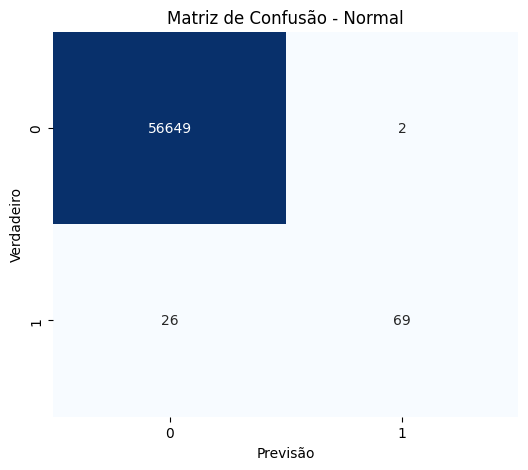

In [22]:
plt.figure(figsize=(6,5))
sns.heatmap(cm_normal, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Previsão')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão - Normal')
plt.show()

### Out of Bag vs Teste

#### OOB

In [24]:
print(rf_normal.oob_score_)

0.9995506212001057


In [39]:
oob_normal_pred_proba = rf_normal.oob_decision_function_

In [40]:
oob_normal_pred = np.argmax(oob_normal_pred_proba, axis=1)

In [41]:
f1_oob_normal = f1_score(y_train, oob_normal_pred)

In [42]:
print("F1 Score OOB (Normal):", f1_oob_normal)

F1 Score OOB (Normal): 0.8526011560693642


#### Teste

In [43]:
y_pred_normal = rf_normal.predict(X_test)

In [44]:
f1_test = f1_score(y_test, y_pred_normal)

In [45]:
print(f"F1-score (Teste): {f1_test:.4f}")

F1-score (Teste): 0.8313


## Hiperparâmetros

### Como funciona?

Busca hiperparâmetros para buscar a melhro combinação pro modelo (maior score de uma métrica escolhida)

Para isso, é necessário definir um grid dos hiperparâmetros que serão testados

#### Grid Search
* Testa todas as combinações possíveis dos hiperparâmetros do grid (exaustivamente)
* O melhor conjunto dentro do grid é encontrado
* Complexidade muito alta

#### Random Search
* Escolhe aleatoriamente um número limitado de combinações dos hiperparâmetros
* Cria uma "amostra" do grid
* Pode pedir pra sortear valores
* Menor complexidade 

#### Optuna (GOAT)
* Aprende quais regiões do grid trazem os melhores resultados
* Ajusta a busca com tentativas anteriores
* Para cedo em combinações ruins

### Random Search

In [29]:
random_grid = {
    'n_estimators': stats.randint(50, 100),
    'max_depth': [10, 15],
    'min_samples_split': stats.randint(2, 5),
    'max_features': ['sqrt']
}

In [30]:
random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=random_grid,
    n_iter=5,
    cv=2,
    scoring='f1',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

In [31]:
X_small = X_train.sample(frac=0.3, random_state=42)
y_small = y_train.loc[X_small.index]

In [32]:
random_search.fit(X_small, y_small)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


,estimator,RandomForestC...ndom_state=42)
,param_distributions,"{'max_depth': [10, 15], 'max_features': ['sqrt'], 'min_samples_split': <scipy.stats....t 0x12066b2c0>, 'n_estimators': <scipy.stats....t 0x12066b110>}"
,n_iter,5
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,2
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [33]:
print("Melhores parâmetros - Random Search")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

Melhores parâmetros - Random Search
  max_depth: 10
  max_features: sqrt
  min_samples_split: 3
  n_estimators: 68


In [34]:
random_score = random_search.score(X_test, y_test)
print(f"\nScore Random Search: {random_score:.4f}")


Score Random Search: 0.8263


#### Teste

In [77]:
y_pred_rs_test = random_search.predict(X_test)

In [78]:
y_pred_rs_train = random_search.predict(X_train)

In [79]:
results_rs_test = calculate_metrics(y_test, y_pred_rs_test, random_search.predict_proba(X_test)[:,1], "Random Search")
results_rs_train = calculate_metrics(y_train, y_pred_rs_train, random_search.predict_proba(X_train)[:,1], "Random Search")

In [80]:
cm_rs = confusion_matrix(y_test, y_pred_rs_test)

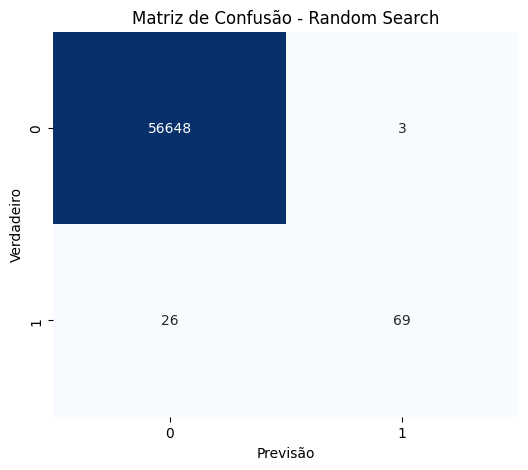

In [81]:
plt.figure(figsize=(6,5))
sns.heatmap(cm_rs, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Previsão')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão - Random Search')
plt.show()

### Optuna

In [53]:
from optuna.pruners import MedianPruner

In [66]:
def objective(trial):
    # grid
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 10, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 5)
    max_features = trial.suggest_categorical('max_features', ['sqrt'])
    
    # model
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )
    
    # cross-validation
    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_small, y_small, cv=cv, scoring='f1', n_jobs=-1)
    return np.mean(scores)

In [55]:
study = optuna.create_study(direction='maximize', pruner=MedianPruner())

[I 2025-10-17 11:46:20,275] A new study created in memory with name: no-name-29a384c4-6879-4498-9eef-fdb905199e51


In [56]:
study.optimize(objective, n_trials=10, n_jobs=-1, show_progress_bar=True)

Best trial: 4. Best value: 0.76335:  10%|█         | 1/10 [00:25<03:48, 25.34s/it]

[I 2025-10-17 11:46:46,541] Trial 4 finished with value: 0.7633495145631068 and parameters: {'n_estimators': 62, 'max_depth': 10, 'min_samples_split': 3, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.7633495145631068.


Best trial: 1. Best value: 0.765:  20%|██        | 2/10 [00:25<01:26, 10.81s/it]  

[I 2025-10-17 11:46:47,188] Trial 1 finished with value: 0.765 and parameters: {'n_estimators': 68, 'max_depth': 11, 'min_samples_split': 4, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.765.


Best trial: 1. Best value: 0.765:  30%|███       | 3/10 [00:40<01:28, 12.59s/it]

[I 2025-10-17 11:47:01,886] Trial 8 finished with value: 0.7561847168774052 and parameters: {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 4, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.765.


Best trial: 1. Best value: 0.765:  40%|████      | 4/10 [00:46<00:59,  9.92s/it]

[I 2025-10-17 11:47:07,712] Trial 6 finished with value: 0.7633495145631068 and parameters: {'n_estimators': 56, 'max_depth': 15, 'min_samples_split': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.765.


Best trial: 1. Best value: 0.765:  50%|█████     | 5/10 [00:52<00:41,  8.32s/it]

[I 2025-10-17 11:47:13,212] Trial 0 finished with value: 0.7537341299477222 and parameters: {'n_estimators': 133, 'max_depth': 20, 'min_samples_split': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.765.


Best trial: 2. Best value: 0.768063:  60%|██████    | 6/10 [00:55<00:26,  6.71s/it]

[I 2025-10-17 11:47:16,774] Trial 2 finished with value: 0.7680625449317038 and parameters: {'n_estimators': 145, 'max_depth': 18, 'min_samples_split': 4, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.7680625449317038.


Best trial: 2. Best value: 0.768063:  70%|███████   | 7/10 [00:56<00:14,  4.96s/it]

[I 2025-10-17 11:47:18,133] Trial 5 finished with value: 0.7512849800114221 and parameters: {'n_estimators': 140, 'max_depth': 19, 'min_samples_split': 2, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.7680625449317038.


Best trial: 2. Best value: 0.768063:  80%|████████  | 8/10 [01:02<00:10,  5.02s/it]

[I 2025-10-17 11:47:23,287] Trial 3 finished with value: 0.767156862745098 and parameters: {'n_estimators': 56, 'max_depth': 20, 'min_samples_split': 3, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.7680625449317038.


Best trial: 2. Best value: 0.768063:  90%|█████████ | 9/10 [01:06<00:04,  4.77s/it]

[I 2025-10-17 11:47:27,494] Trial 9 finished with value: 0.7678346810422283 and parameters: {'n_estimators': 116, 'max_depth': 13, 'min_samples_split': 5, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.7680625449317038.


Best trial: 2. Best value: 0.768063: 100%|██████████| 10/10 [01:06<00:00,  6.66s/it]

[I 2025-10-17 11:47:27,778] Trial 7 finished with value: 0.7571644042232277 and parameters: {'n_estimators': 78, 'max_depth': 19, 'min_samples_split': 5, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.7680625449317038.


In [57]:
print("Melhor valor de F1:", study.best_value)
print("Melhores hiperparâmetros:", study.best_params)

Melhor valor de F1: 0.7680625449317038
Melhores hiperparâmetros: {'n_estimators': 145, 'max_depth': 18, 'min_samples_split': 4, 'max_features': 'sqrt'}


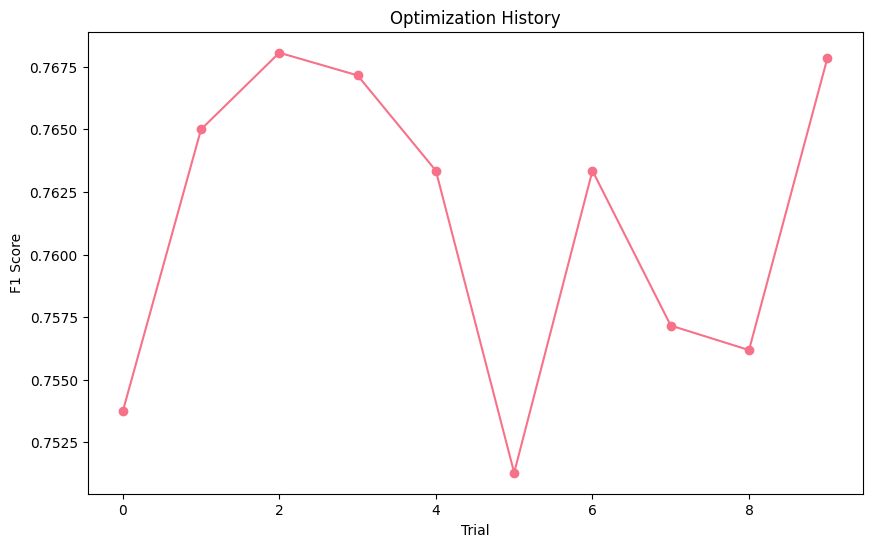

In [74]:
scores = [t.value for t in study.trials if t.value is not None]
plt.plot(scores, marker='o')
plt.title("Optimization History")
plt.xlabel("Trial")
plt.ylabel("F1 Score")
plt.show()

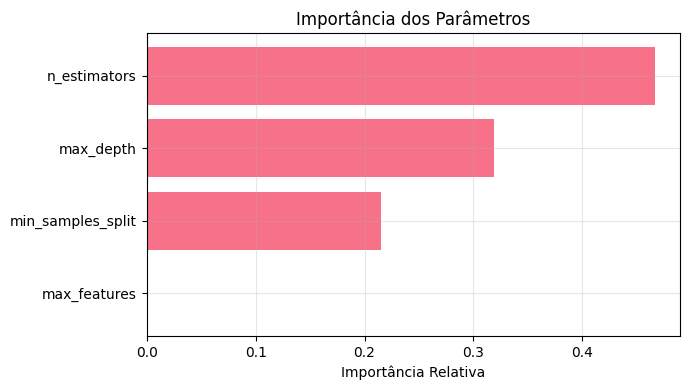

In [76]:
importances = optuna.importance.get_param_importances(study)

params = list(importances.keys())
scores = list(importances.values())

plt.figure(figsize=(7, 4))
plt.barh(params, scores)
plt.xlabel("Importância Relativa")
plt.title("Importância dos Parâmetros")
plt.gca().invert_yaxis()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### Treinamento com melhores parâmetros

In [84]:
best_params = study.best_params
print("Melhores hiperparâmetros:", best_params)

Melhores hiperparâmetros: {'n_estimators': 145, 'max_depth': 18, 'min_samples_split': 4, 'max_features': 'sqrt'}


In [85]:
optuna_model = RandomForestClassifier(
    **best_params,
    random_state=42,
    n_jobs=-1
)

In [87]:
optuna_model.fit(X_train, y_train)

,n_estimators,145
,criterion,'gini'
,max_depth,18
,min_samples_split,4
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [89]:
y_pred_opt_test = optuna_model.predict(X_test)
y_pred_opt_train = optuna_model.predict(X_train)

In [90]:
results_optuna_test = calculate_metrics(y_test, y_pred_opt_test, optuna_model.predict_proba(X_test)[:,1], "Optuna")
results_optuna_train = calculate_metrics(y_train, y_pred_opt_train, optuna_model.predict_proba(X_train)[:,1], "Optuna")

## Comparação dos Modelos

In [91]:
df_results_test = pd.DataFrame([results_normal_test, results_rs_test, results_optuna_test])

In [92]:
df_results_test

,Modelo,Precision,Recall,F1
0,Normal,0.971831,0.726316,0.831325
1,Random Search,0.958333,0.726316,0.826347
2,Optuna,0.985915,0.736842,0.843373


In [93]:
df_results_train = pd.DataFrame([results_normal_train, results_rs_train, results_optuna_train])

In [94]:
df_results_train

,Modelo,Precision,Recall,F1
0,Normal,1.00,0.997354,0.998675
1,Random Search,0.95,0.804233,0.871060
2,Optuna,1.00,0.904762,0.950000
